# Présentation des résultats

Chargement des Packages nécessaires

In [42]:
using CSV
using DataFrames
using DataFramesMeta
using Dates
using StatsPlots
using Statistics
using Temporal
using GLM
using TimeSeries: TimeArray 
using StatsBase
using Forecast
using LinearAlgebra

## Paris


In [43]:
# Charger les données
df = CSV.read("data_station_extract_script/data_rr/ORLY.txt", DataFrame, skipto = 21, header = 20, comment="#", dateformat = "yyyymmdd", types=Dict(:DATE => Date), normalizenames=true)
df_drias = CSV.read("data_drias/Mod1_pluie/orly.txt",DataFrame, header = 48, comment="#", dateformat = "yyyymmdd", types=Dict(:Date => Date), normalizenames=true)
df_mod2 = CSV.read("data_drias/Mod2_pluie/orly.txt",DataFrame, header = 47, comment="#", dateformat = "yyyymmdd", types=Dict(:Date => Date), normalizenames=true)

# Filtrer les données entre 1951 et 2006
df_filtered = filter(row -> year(row.DATE) >= 1955 && year(row.DATE) <= 2005, df)
df_filtered_drias = filter(row -> year(row.Date) >= 1955 && year(row.Date) <= 2005, df_drias)
df_filtered_mod2 = filter(row -> year(row.Date) >= 1955 && year(row.Date) <= 2005, df_mod2)

18628×2 DataFrame
   Row │ Date        mm      
       │ Date        Float64 
───────┼─────────────────────
     1 │ 1955-01-01    0.0
     2 │ 1955-01-02    3.508
     3 │ 1955-01-03    4.37
     4 │ 1955-01-04    0.0
     5 │ 1955-01-05    0.804
     6 │ 1955-01-06    0.726
     7 │ 1955-01-07    2.098
     8 │ 1955-01-08    5.836
   ⋮   │     ⋮          ⋮
 18622 │ 2005-12-25    2.726
 18623 │ 2005-12-26    0.0
 18624 │ 2005-12-27    0.0
 18625 │ 2005-12-28    0.0
 18626 │ 2005-12-29    0.0
 18627 │ 2005-12-30    0.444
 18628 │ 2005-12-31    0.0
           18613 rows omitted

### Premières Analyses

### Moyenne en regroupant les mois


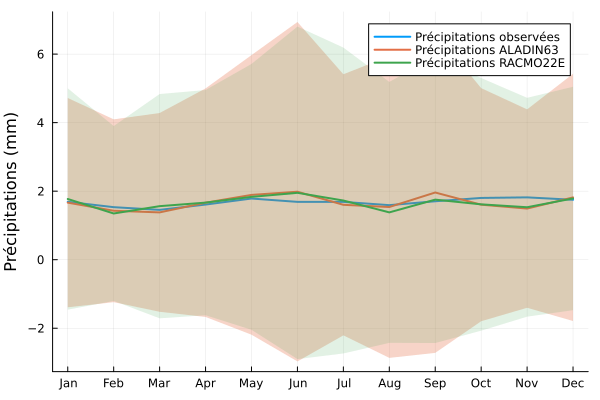

In [9]:
# Conversion factor to °C
factor = 0.1

df_month = @chain df_filtered begin
    @subset(:Q_RR .!= 9) # remove missing 
    @transform(:MONTH = month.(:DATE)) # add month column
    @by(:MONTH, :MONTHLY_MEAN = mean(:RR)*factor, :MONTHLY_STD = std(:RR)*factor) # grouby MONTH + takes the mean/std in each category 
end
df_month_drias = @chain df_filtered_drias begin
    @subset(:mm .!= 9) # remove missing 
    @transform(:MONTH = month.(:Date)) # add month column
    @by(:MONTH, :MONTHLY_MEAN = mean(:mm), :MONTHLY_STD = std(:mm)) # grouby MONTH + takes the mean/std in each category 
end

df_month_mod2 = @chain df_filtered_mod2 begin
    @subset(:mm .!= 9) # remove missing 
    @transform(:MONTH = month.(:Date)) # add month column
    @by(:MONTH, :MONTHLY_MEAN = mean(:mm), :MONTHLY_STD = std(:mm)) # grouby MONTH + takes the mean/std in each category 
end

@df df_month plot(monthabbr.(1:12), :MONTHLY_MEAN, label = "Précipitations observées", linewidth=2)
ylabel!("Précipitations (mm)")
@df df_month_drias plot!(monthabbr.(1:12), :MONTHLY_MEAN, ribbon = :MONTHLY_STD, fillalpha = 0.3, label = "Précipitations ALADIN63", linewidth=2)
@df df_month_mod2 plot!(monthabbr.(1:12), :MONTHLY_MEAN, ribbon = :MONTHLY_STD, fillalpha = 0.15, label = "Précipitations RACMO22E", linewidth=2)
#savefig("Précipitations_moyennes_strasbourg.pdf")

Ajustement des données

In [44]:
# Calculer la moyenne et l'écart type pour chaque date
df_daily = @chain df_filtered begin
    @subset(:Q_RR .!= 9) # Supprimer les valeurs manquantes 
    @transform(:YEAR = year.(:DATE)) # Ajouter une colonne pour l'année
    @by(:DATE, :DAILY_MEAN = mean(:RR)*factor, :DAILY_STD = std(:RR)*factor) # Grouper par DATE et prendre la moyenne / écart type
end
# Calculer la moyenne et l'écart type pour chaque date
df_daily_drias = @chain df_filtered_drias begin
    @subset(:mm .!= 9) # Supprimer les valeurs manquantes 
    @transform(:YEAR = year.(:Date)) # Ajouter une colonne pour l'année
    @by(:Date, :DAILY_MEAN = mean(:mm), :DAILY_STD = std(:mm)) # Grouper par DATE et prendre la moyenne / écart type
end
# Convertir les données en une série temporelle avec TimeSeries
my_ts = TimeArray(df_daily.DATE, df_daily.DAILY_MEAN)
my_ts_drias = TimeArray(df_daily_drias.Date, df_daily_drias.DAILY_MEAN)

# Extraire les valeurs numériques de la série temporelle
data_values = values(my_ts)
data_values_drias = values(my_ts_drias)

18628-element Vector{Float64}:
 0.0
 3.339
 3.528
 0.868
 2.883
 2.521
 2.167
 3.531
 0.0
 2.813
 ⋮
 0.023
 0.0
 0.147
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

### Séries temporelles et tendances

Histogramme

In [45]:


# Fonction pour calculer la somme cumulée des pluies par année
function cumulative_rainfall_per_year(df)
    @chain df begin
        @transform(:YEAR = year.(:DATE)) # Ajouter une colonne pour l'année
        @by(:YEAR, :YEARLY_SUM = sum(:RR)) # Grouper par YEAR et prendre la somme
    end
end

# Appliquer la fonction à nos DataFrames
df_cumulative = cumulative_rainfall_per_year(df_daily)
df_cumulative_drias = cumulative_rainfall_per_year(df_daily_drias)

# Tracer la série finale avec un histogramme
histogram([df_cumulative.YEARLY_SUM, df_cumulative_drias.YEARLY_SUM],
    label=["Série Originale" "Série DRIAS"],
    bins=20,
    title="Histogramme des sommes cumulées des pluies par année",
    xlabel="Somme cumulée des pluies (mm)",
    ylabel="Fréquence",
    legend=:topright)


ArgumentError: ArgumentError: column name :RR not found in the data frame

Tracé des deux avec moyennes mobiles classiques

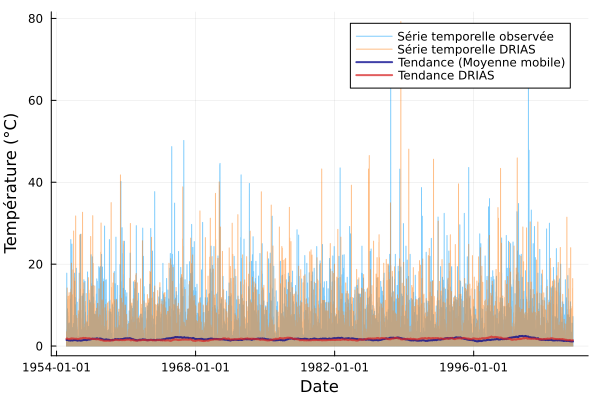

In [11]:
function moyenne_mobile(data::Vector{T}, window_size::Int) where T
    n = length(data)
    trend = similar(data, T)
    for i in 1:n
        start_idx = max(1, i - window_size ÷ 2)
        end_idx = min(n, i + window_size ÷ 2)
        trend[i] = mean(@view(data[start_idx:end_idx]))
    end
    return trend
end

# Calculer la tendance par moyenne mobile avec une fenêtre de taille 730 (deux ans)
trend_values = moyenne_mobile(df_daily.DAILY_MEAN, 730)
trend_values_drias = moyenne_mobile(df_daily_drias.DAILY_MEAN, 730)

# Convertir les données en une série temporelle
datats = TimeArray(df_daily.DATE, df_daily.DAILY_MEAN)
datats_drias = TimeArray(df_daily_drias.Date, df_daily_drias.DAILY_MEAN)

# Tracer la série temporelle avec la tendance
plot(datats,  alpha=:0.5,label="Série temporelle observée", xlabel="Date", ylabel="Température (°C)", legend=:topright)
plot!(datats_drias,   palette =:tab10, alpha=:0.5, label="Série temporelle DRIAS", xlabel="Date", ylabel="Température (°C)")
plot!(df_daily.DATE, color=:darkblue,alpha=:0.75, trend_values, label="Tendance (Moyenne mobile)", linewidth=2)
plot!(df_daily_drias.Date, palette =:tab10,alpha=:0.75, trend_values_drias, label="Tendance DRIAS", linewidth=2)


Tracé des deux avec moyennes mobiles gaussien


Calcul des tendances avec le package Forecast

In [13]:
stl_df = stl(df_daily,730; robust=true, spm=true)
stl_df_drias = stl(df_daily_drias,730; robust=true, spm=true)
stl_df.decomposition
stl_df_drias.decomposition

┌ Info: Corvengence achieved (< 0.01); Stopping computation...
└ @ Forecast /Users/mario/.julia/packages/Forecast/Pu4g0/src/stl.jl:165
┌ Info: Corvengence achieved (< 0.01); Stopping computation...
└ @ Forecast /Users/mario/.julia/packages/Forecast/Pu4g0/src/stl.jl:165


18628×4 DataFrame
   Row │ Timestamp   Seasonal    Trend    Remainder 
       │ Date        Float64     Float64  Float64   
───────┼────────────────────────────────────────────
     1 │ 1955-01-01  -0.190781   1.77799  -1.58721
     2 │ 1955-01-02  -0.177346   1.77797   1.73837
     3 │ 1955-01-03  -0.164577   1.77796   1.91462
     4 │ 1955-01-04  -0.152482   1.77795  -0.757465
     5 │ 1955-01-05  -0.141071   1.77794   1.24614
     6 │ 1955-01-06  -0.130355   1.77792   0.873431
     7 │ 1955-01-07  -0.120346   1.77791   0.509432
     8 │ 1955-01-08  -0.111055   1.7779    1.86415
   ⋮   │     ⋮           ⋮          ⋮         ⋮
 18622 │ 2005-12-25   0.45621    1.49992  -1.80914
 18623 │ 2005-12-26   0.488079   1.4999   -1.98798
 18624 │ 2005-12-27   0.520033   1.49989  -2.01992
 18625 │ 2005-12-28   0.55204    1.49987  -2.05191
 18626 │ 2005-12-29   0.584065   1.49986  -2.08392
 18627 │ 2005-12-30   0.616083   1.49985  -2.11593
 18628 │ 2005-12-31   0.648085   1.49984  -2.14792
                                  18613 rows omitted

Tracé des deux avec moyennes mobiles du package Forecast


### SAISONNALITÉ

Saisonnalité avec Forecast

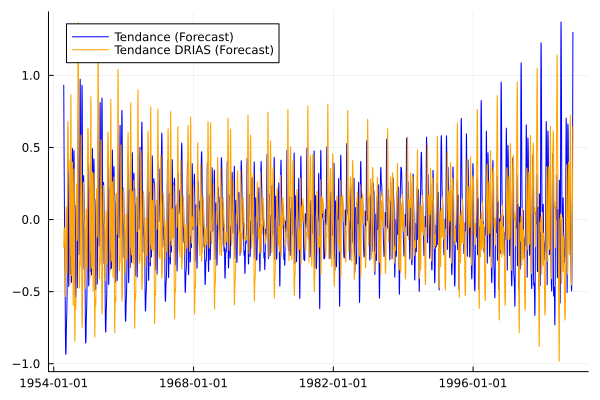

In [15]:
@df stl_df.decomposition plot(:Timestamp, :Seasonal,  main = "Tendances", label="Tendance (Forecast)", color=:blue)
@df stl_df_drias.decomposition plot!(:Timestamp, :Seasonal, label="Tendance DRIAS (Forecast)", color=:orange)

### BRUIT

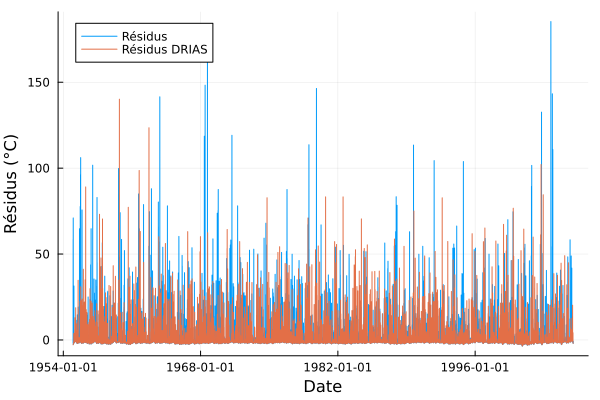

In [37]:

function retiresaisonnalite(data::Vector{T}) where T
    n = length(data)
    saisonnalite = stl_df.decomposition.Seasonal
    tendance = stl_df.decomposition.Trend
    
    for i in 1:n
        data[i] = data[i] - saisonnalite[i] - tendance[i]
    end
    
    return data
end

# Calculer la saisonnalité 
residus = retiresaisonnalite(df_daily.DAILY_MEAN)
residus_drias = retiresaisonnalite(df_daily_drias.DAILY_MEAN)


# Tracer la série temporelle de la saisonnalité
plot(df_daily.DATE, residus, label="Résidus", xlabel="Date", ylabel="Résidus (°C)")
plot!(df_daily_drias.Date, residus_drias, label="Résidus DRIAS", xlabel="Date", ylabel="Résidus (°C)")

### Analyse des résidus

### Autocorrélogrammes de la série résiduelle

Autocorrélogramme partiel


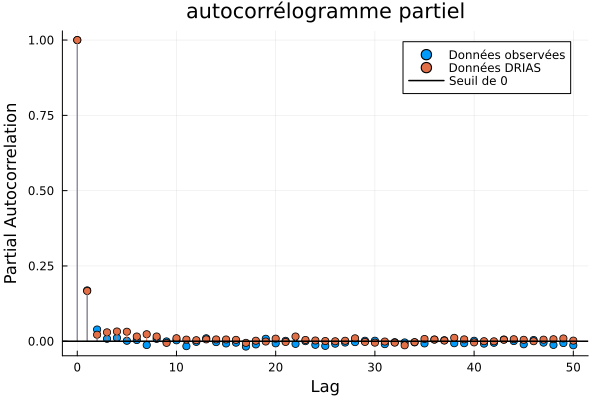

In [18]:
# Calculer l'autocorrélogramme partiel avec un nombre maximal de décalages spécifié
maxlag = 50 # Définir le nombre maximal de décalages
lags = collect(0:maxlag) # Créer une plage de décalages
pacf_values_res = StatsBase.pacf(residus, lags)
pacf_values_drias_res = StatsBase.pacf(residus_drias, lags)

plot(0:maxlag, pacf_values_res, label = "Données observées", xlabel="Lag", ylabel="Partial Autocorrelation", title="autocorrélogramme partiel", markershape=:circle, line=:stem)
plot!(0:maxlag, pacf_values_drias_res, label = "Données DRIAS", markershape=:circle, line=:stem)
hline!([0], color=:black, linewidth=1.5, label = "Seuil de 0")

Autocorrélogramme simple


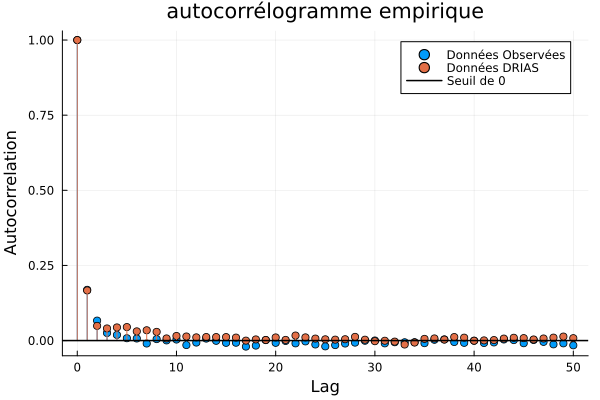

In [19]:
autocor_values = autocor(residus, lags)
autocor_values_drias = autocor(residus_drias, lags)

# Tracer l'autocorrélogramme empirique avec les points reliés à l'axe des abscisses et une droite d'équation nulle
plot(0:maxlag, autocor_values, label = "Données Observées", xlabel="Lag", ylabel="Autocorrelation", title="autocorrélogramme empirique", markershape=:circle, line=:stem)
plot!(0:maxlag, autocor_values_drias, label = "Données DRIAS", markershape=:circle, line=:stem)
hline!([0], color=:black, linewidth=1.5, label = "Seuil de 0")

### Estimation des coefficients de l'AR(2)

Avec notre code


In [20]:
# Construire les matrices pour l'ajustement AR(2)
n = length(residus)
X = hcat(residus[2:end-1], residus[1:end-2])
X_drias = hcat(residus_drias[2:end-1], residus_drias[1:end-2])
y_target = residus[3:end]
y_target_drias = residus_drias[3:end]

# Estimer les coefficients en utilisant les moindres carrés
coefficients = X \ y_target
coefficients_drias = X_drias \ y_target_drias


# Afficher les coefficients estimés
println("Coefficients historiques estimés : ", coefficients)
println("Coefficients estimés pour DRIAS: ", coefficients_drias)



Coefficients historiques estimés : [0.1622783125220717, 0.038994527445315286]
Coefficients estimés pour DRIAS: [0.16320881834420806, 0.021672675365376103]


Données historiques avec Forecast


In [21]:
# Ajuster un modèle AR(2) sur les résidus
model = ar(residus, 2)
model_drias = ar(residus_drias, 2)

# Afficher les résultats
println(model)
println(model_drias)


Multivariate Autoregressive Model

    ar(X, order=2, constant=true)

Residuals Summary
┌──────────┬──────────┬──────────┬──────────┬──────────────┬───────────┬─────────┬───────────┐
│ Variable │      Min │       1Q │   Median │         Mean │        3Q │     Max │ H0 Normal │
├──────────┼──────────┼──────────┼──────────┼──────────────┼───────────┼─────────┼───────────┤
│       x1 │ -10.7562 │ -1.53106 │ -1.16961 │ -1.65943e-17 │ -0.201358 │ 64.5414 │       0.0 │
└──────────┴──────────┴──────────┴──────────┴──────────────┴───────────┴─────────┴───────────┘
┌──────────┬──────────────┬──────────┬──────────┬──────────┐
│ Variable │         Mean │ Variance │ Skewness │ Kurtosis │
├──────────┼──────────────┼──────────┼──────────┼──────────┤
│       x1 │ -1.65943e-17 │  13.5698 │  4.38961 │  32.6717 │
└──────────┴──────────────┴──────────┴──────────┴──────────┘

Coefficients

Φ0
┌         ┐
│ 0.0     │
└         ┘
Φ1
┌           ┐
│ 0.162 *** │
└           ┘
Φ2
┌           ┐
│ 0.039 *** │
└ 

Données DRIAS avec Forecast

## Montpellier

In [29]:
# Charger les données
df = CSV.read("data_station_extract_script/data_rr/MONTPELLIER.txt", DataFrame, skipto = 21, header = 20, comment="#", dateformat = "yyyymmdd", types=Dict(:DATE => Date), normalizenames=true)
df_drias = CSV.read("data_drias/Mod1_pluie/montpellier.txt",DataFrame, header = 48, comment="#", dateformat = "yyyymmdd", types=Dict(:Date => Date), normalizenames=true)
df_mod2 = CSV.read("data_drias/Mod2_pluie/montpellier.txt",DataFrame, header = 47, comment="#", dateformat = "yyyymmdd", types=Dict(:Date => Date), normalizenames=true)

# Filtrer les données entre 1951 et 2006
df_filtered = filter(row -> year(row.DATE) >= 1955 && year(row.DATE) <= 2005, df)
df_filtered_drias = filter(row -> year(row.Date) >= 1955 && year(row.Date) <= 2005, df_drias)
df_filtered_mod2 = filter(row -> year(row.Date) >= 1955 && year(row.Date) <= 2005, df_mod2)

18628×2 DataFrame
   Row │ Date        mm      
       │ Date        Float64 
───────┼─────────────────────
     1 │ 1955-01-01    0.0
     2 │ 1955-01-02    0.0
     3 │ 1955-01-03    0.0
     4 │ 1955-01-04    0.0
     5 │ 1955-01-05    0.0
     6 │ 1955-01-06    0.0
     7 │ 1955-01-07    0.0
     8 │ 1955-01-08    0.0
   ⋮   │     ⋮          ⋮
 18622 │ 2005-12-25    2.404
 18623 │ 2005-12-26   28.273
 18624 │ 2005-12-27    0.101
 18625 │ 2005-12-28    0.0
 18626 │ 2005-12-29    0.0
 18627 │ 2005-12-30    0.0
 18628 │ 2005-12-31    0.0
           18613 rows omitted

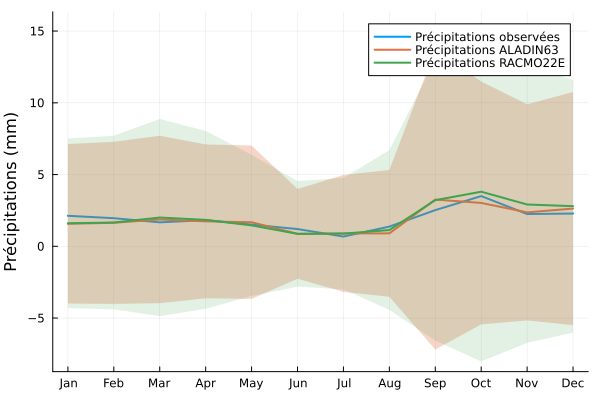

In [25]:
# Conversion factor to °C
factor = 0.1

df_month = @chain df_filtered begin
    @subset(:Q_RR .!= 9) # remove missing 
    @transform(:MONTH = month.(:DATE)) # add month column
    @by(:MONTH, :MONTHLY_MEAN = mean(:RR)*factor, :MONTHLY_STD = std(:RR)*factor) # grouby MONTH + takes the mean/std in each category 
end
df_month_drias = @chain df_filtered_drias begin
    @subset(:mm .!= 9) # remove missing 
    @transform(:MONTH = month.(:Date)) # add month column
    @by(:MONTH, :MONTHLY_MEAN = mean(:mm), :MONTHLY_STD = std(:mm)) # grouby MONTH + takes the mean/std in each category 
end

df_month_mod2 = @chain df_filtered_mod2 begin
    @subset(:mm .!= 9) # remove missing 
    @transform(:MONTH = month.(:Date)) # add month column
    @by(:MONTH, :MONTHLY_MEAN = mean(:mm), :MONTHLY_STD = std(:mm)) # grouby MONTH + takes the mean/std in each category 
end

@df df_month plot(monthabbr.(1:12), :MONTHLY_MEAN, label = "Précipitations observées", linewidth=2)
ylabel!("Précipitations (mm)")
@df df_month_drias plot!(monthabbr.(1:12), :MONTHLY_MEAN, ribbon = :MONTHLY_STD, fillalpha = 0.3, label = "Précipitations ALADIN63", linewidth=2)
@df df_month_mod2 plot!(monthabbr.(1:12), :MONTHLY_MEAN, ribbon = :MONTHLY_STD, fillalpha = 0.15, label = "Précipitations RACMO22E", linewidth=2)
#savefig("Précipitations_moyennes_strasbourg.pdf")

In [30]:
# Calculer la moyenne et l'écart type pour chaque date
df_daily = @chain df_filtered begin
    @subset(:Q_RR .!= 9) # Supprimer les valeurs manquantes 
    @transform(:YEAR = year.(:DATE)) # Ajouter une colonne pour l'année
    @by(:DATE, :DAILY_MEAN = mean(:RR)*factor, :DAILY_STD = std(:RR)*factor) # Grouper par DATE et prendre la moyenne / écart type
end
# Calculer la moyenne et l'écart type pour chaque date
df_daily_drias = @chain df_filtered_drias begin
    @subset(:mm .!= 9) # Supprimer les valeurs manquantes 
    @transform(:YEAR = year.(:Date)) # Ajouter une colonne pour l'année
    @by(:Date, :DAILY_MEAN = mean(:mm), :DAILY_STD = std(:mm)) # Grouper par DATE et prendre la moyenne / écart type
end
# Convertir les données en une série temporelle avec TimeSeries
my_ts = TimeArray(df_daily.DATE, df_daily.DAILY_MEAN)
my_ts_drias = TimeArray(df_daily_drias.Date, df_daily_drias.DAILY_MEAN)

# Extraire les valeurs numériques de la série temporelle
data_values = values(my_ts)
data_values_drias = values(my_ts_drias)

18627-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 5.728
 0.418
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [31]:
stl_df_mtp = stl(df_daily,365; robust=true, spm=true)
stl_df_drias_mtp = stl(df_daily_drias,365; robust=true, spm=true)
stl_df_mtp.decomposition
stl_df_drias_mtp.decomposition

┌ Info: Corvengence achieved (< 0.01); Stopping computation...
└ @ Forecast /Users/mario/.julia/packages/Forecast/Pu4g0/src/stl.jl:165
┌ Info: Corvengence achieved (< 0.01); Stopping computation...
└ @ Forecast /Users/mario/.julia/packages/Forecast/Pu4g0/src/stl.jl:165


18627×4 DataFrame
   Row │ Timestamp   Seasonal  Trend      Remainder 
       │ Date        Float64   Float64    Float64   
───────┼────────────────────────────────────────────
     1 │ 1955-01-01  1.83821   0.392022   -2.23023
     2 │ 1955-01-02  1.58697   0.400165   -1.98714
     3 │ 1955-01-03  1.35533   0.408296   -1.76363
     4 │ 1955-01-04  1.14183   0.416417   -1.55825
     5 │ 1955-01-05  0.9452    0.424526   -1.36973
     6 │ 1955-01-06  0.764437  0.432624   -1.19706
     7 │ 1955-01-07  0.598756  0.440711   -1.03947
     8 │ 1955-01-08  0.447485  0.448787   -0.896272
   ⋮   │     ⋮          ⋮          ⋮          ⋮
 18621 │ 2005-12-25  0.494791  0.13537    -0.630161
 18622 │ 2005-12-26  0.554138  0.129062   -0.6832
 18623 │ 2005-12-27  0.625843  0.122753   -0.748596
 18624 │ 2005-12-28  0.710584  0.116441   -0.827025
 18625 │ 2005-12-29  0.808979  0.110126   -0.919106
 18626 │ 2005-12-30  0.921448  0.10381    -1.02526
 18627 │ 2005-12-31  1.04818   0.0974917  -1.14567
                                  18612 rows omitted

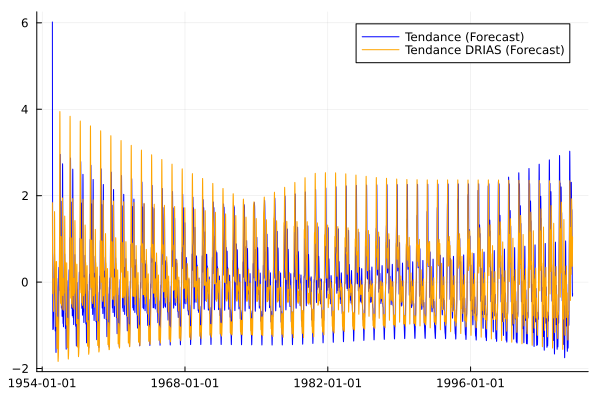

In [36]:
@df stl_df_mtp.decomposition plot(:Timestamp, :Seasonal,  main = "Tendances", label="Tendance (Forecast)", color=:blue)
@df stl_df_drias_mtp.decomposition plot!(:Timestamp, :Seasonal, label="Tendance DRIAS (Forecast)", color=:orange)